<a href="https://colab.research.google.com/github/haidiralimarsaoly/deep_learning/blob/main/klasifikasi_karakter_marvel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download haidirali/char-marvel
!mkdir marvel

In [ ]:
!unzip /content/char-marvel.zip -d /content/marvel
     

In [5]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
     

In [6]:
dataset_path = Path(r'/content/marvel')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))
     

In [7]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()
     

,image,label
0,/content/marvel/spiderman/spiderman (75).jpg,spiderman
1,/content/marvel/spiderman/spiderman (6).jpg,spiderman
2,/content/marvel/spiderman/spiderman (23).jpg,spiderman
3,/content/marvel/spiderman/spiderman (2).jpg,spiderman
4,/content/marvel/spiderman/spiderman (69).jpg,spiderman


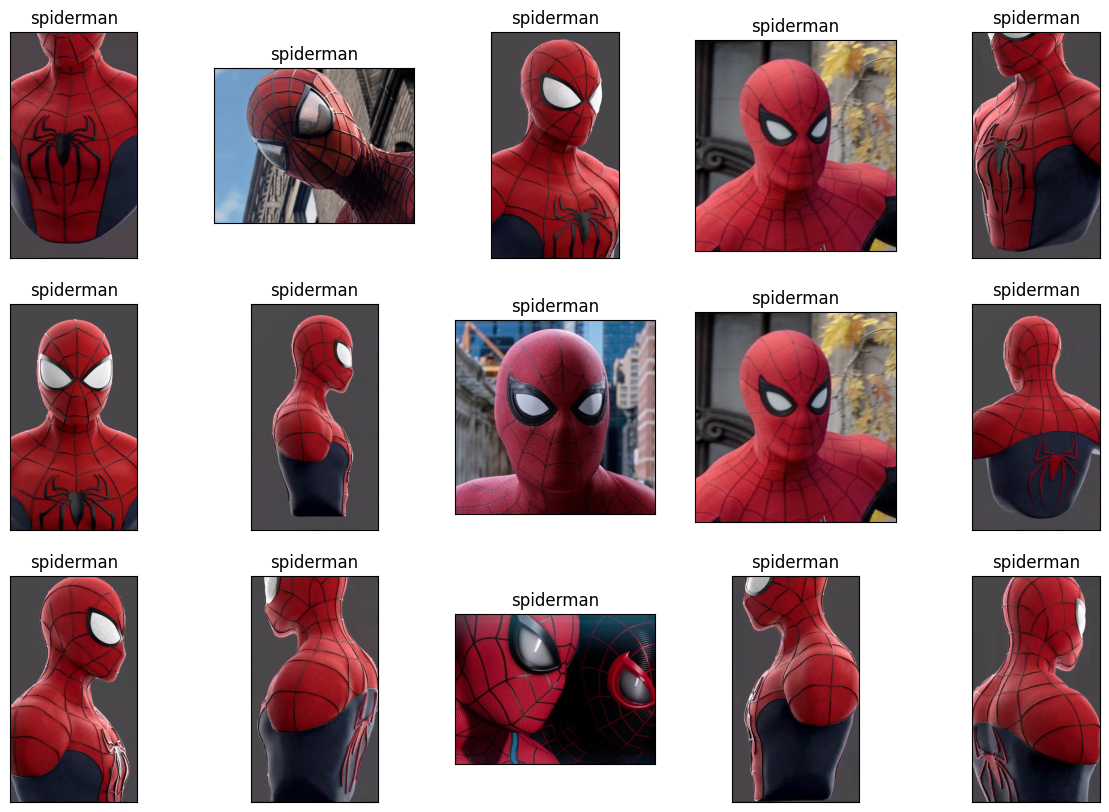

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()
     

In [9]:
df.label.value_counts()
 

spiderman    100
thor         100
iron man     100
hulk         100
Name: label, dtype: int64

In [10]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()
   

spiderman    100
thor         100
iron man     100
hulk         100
Name: label, dtype: int64

In [11]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)
   

In [12]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)
     

Found 224 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.
Found 56 validated image filenames belonging to 4 classes.


In [13]:
input_shape = (200, 200, 3)
     

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()
     

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [15]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, batch_size= 512, validation_data=val, epochs=100, callbacks=callback)
     

Epoch 1/100
7/7 [==============================] - 21s 1s/step - loss: 1.3574 - accuracy: 0.2857 - val_loss: 1.2004 - val_accuracy: 0.5179
Epoch 2/100
7/7 [==============================] - 7s 1s/step - loss: 0.9365 - accuracy: 0.5893 - val_loss: 0.6061 - val_accuracy: 0.8036
Epoch 3/100
7/7 [==============================] - 7s 1s/step - loss: 0.7804 - accuracy: 0.6562 - val_loss: 0.5204 - val_accuracy: 0.7500
Epoch 4/100
7/7 [==============================] - 7s 960ms/step - loss: 0.6131 - accuracy: 0.7232 - val_loss: 0.3918 - val_accuracy: 0.8750
Epoch 5/100
7/7 [==============================] - 7s 1s/step - loss: 0.4522 - accuracy: 0.8393 - val_loss: 0.2546 - val_accuracy: 0.9107
Epoch 6/100
7/7 [==============================] - 6s 894ms/step - loss: 0.3109 - accuracy: 0.8795 - val_loss: 0.6805 - val_accuracy: 0.8214
Epoch 7/100
7/7 [==============================] - 7s 1s/step - loss: 0.4834 - accuracy: 0.8527 - val_loss: 0.3149 - val_accuracy: 0.8750
Epoch 8/100
7/7 [==========

In [16]:
model.save('model-1.h5')
     

In [17]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
     

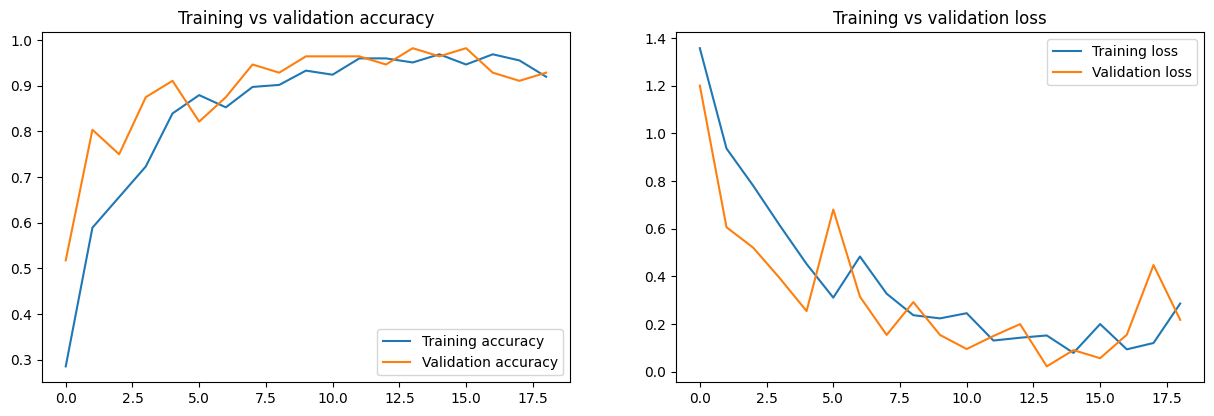

In [18]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()
     


In [19]:
pred = model.predict(test)
     


4/4 [==============================] - 3s 605ms/step


In [20]:
pred = np.argmax(pred, axis=1)
     

In [21]:
labels = train.class_indices
     

In [22]:
labels
     

{'hulk': 0, 'iron man': 1, 'spiderman': 2, 'thor': 3}

In [23]:
labels = dict((v,k) for k, v in labels.items())
     

In [24]:
labels
     

{0: 'hulk', 1: 'iron man', 2: 'spiderman', 3: 'thor'}

In [25]:
y_pred = [labels[k] for k in pred]
     

In [26]:
print(classification_report(x_test.label, y_pred))
     

              precision    recall  f1-score   support

        hulk       0.92      0.74      0.82        31
    iron man       0.76      1.00      0.87        26
   spiderman       1.00      1.00      1.00        30
        thor       1.00      0.94      0.97        33

    accuracy                           0.92       120
   macro avg       0.92      0.92      0.91       120
weighted avg       0.93      0.92      0.92       120



In [27]:
print(confusion_matrix(x_test.label, y_pred))
     

[[23  8  0  0]
 [ 0 26  0  0]
 [ 0  0 30  0]
 [ 2  0  0 31]]


In [28]:
test_accuracy = model.evaluate(test)[1]
     

4/4 [==============================] - 3s 606ms/step - loss: 0.3348 - accuracy: 0.8750
